In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.0 MB/s eta 0:00:0000:01


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shutil import copyfile
from datetime import datetime
sns.set(rc={'figure.figsize': (15, 8)})
from pmdarima.arima import ndiffs
import pmdarima as pm
import time
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
copyfile(src = "../input/store-sales-time-series-forecasting/train.csv", dst = "../working/train.csv")
copyfile(src = "../input/store-sales-time-series-forecasting/test.csv", dst = "../working/test.csv")
copyfile(src = "../input/store-sales-time-series-forecasting/oil.csv", dst = "../working/oil.csv")
copyfile(src = "../input/store-sales-time-series-forecasting/holidays_events.csv", dst = "../working/event.csv")
copyfile(src = "../input/store-sales-time-series-forecasting/transactions.csv", dst = "../working/transaction.csv")
copyfile(src = "../input/store-sales-time-series-forecasting/stores.csv", dst = "../working/store.csv")
copyfile(src = "../input/store-sales-time-series-forecasting/sample_submission.csv", dst = "../working/sample_submission.csv")

'../working/sample_submission.csv'

In [4]:
def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 데이터 점검

## 1) 학습 데이터 점검

In [5]:
df_train = pd.read_csv('train.csv')
print(df_train.shape)
df_train.tail(3)

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [6]:
gap =datetime.strptime('2017-08-15','%Y-%m-%d') - datetime.strptime('2013-01-01','%Y-%m-%d')
print(gap)
df_train.date.unique().shape

1687 days, 0:00:00


(1684,)

In [7]:
df_train.store_nbr.value_counts().sort_index()

1     55572
2     55572
3     55572
4     55572
5     55572
6     55572
7     55572
8     55572
9     55572
10    55572
11    55572
12    55572
13    55572
14    55572
15    55572
16    55572
17    55572
18    55572
19    55572
20    55572
21    55572
22    55572
23    55572
24    55572
25    55572
26    55572
27    55572
28    55572
29    55572
30    55572
31    55572
32    55572
33    55572
34    55572
35    55572
36    55572
37    55572
38    55572
39    55572
40    55572
41    55572
42    55572
43    55572
44    55572
45    55572
46    55572
47    55572
48    55572
49    55572
50    55572
51    55572
52    55572
53    55572
54    55572
Name: store_nbr, dtype: int64

In [8]:
df_train.family.value_counts()

AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED FOODS                90936
POULTRY                       90936
PLAYERS AND ELECTRONICS       90936
PET SUPPLIES                  90936
PERSONAL CARE                 90936
MEATS                         90936
MAGAZINES                     90936
LIQUOR,WINE,BEER              90936
LINGERIE                      90936
LAWN AND GARDEN               90936
LADIESWEAR                    90936
HOME CARE                     90936
HOME AND KITCHEN II           90936
BABY CARE                     90936
HOME AND KITCHEN I            90936
HARDWARE                      90936
GROCERY II                    90936
GROCERY I                     90936
FROZEN FOODS                  90936
EGGS                          90936
DELI                          90936
DAIRY                         90936
CLEANING                      90936
CELEBRATION                 

In [9]:
df_train.family.unique().shape

(33,)

## 1684일 동안 (중간에 3일 휴무) 54개 매장에 있는 33개 품목에 대한 각 판매량 데이터

## 2) 테스트 데이터 점검

In [10]:
df_test = pd.read_csv('test.csv')
print(df_test.shape)
df_test.head(3)

(28512, 5)


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2


In [11]:
gap =datetime.strptime('2017-08-16','%Y-%m-%d') - datetime.strptime('2017-08-31','%Y-%m-%d')
print(gap)
df_test.date.unique().shape

-15 days, 0:00:00


(16,)

In [12]:
df_test.store_nbr.value_counts().sort_index()

1     528
2     528
3     528
4     528
5     528
6     528
7     528
8     528
9     528
10    528
11    528
12    528
13    528
14    528
15    528
16    528
17    528
18    528
19    528
20    528
21    528
22    528
23    528
24    528
25    528
26    528
27    528
28    528
29    528
30    528
31    528
32    528
33    528
34    528
35    528
36    528
37    528
38    528
39    528
40    528
41    528
42    528
43    528
44    528
45    528
46    528
47    528
48    528
49    528
50    528
51    528
52    528
53    528
54    528
Name: store_nbr, dtype: int64

In [13]:
df_test.family.value_counts()

AUTOMOTIVE                    864
HOME APPLIANCES               864
SCHOOL AND OFFICE SUPPLIES    864
PRODUCE                       864
PREPARED FOODS                864
POULTRY                       864
PLAYERS AND ELECTRONICS       864
PET SUPPLIES                  864
PERSONAL CARE                 864
MEATS                         864
MAGAZINES                     864
LIQUOR,WINE,BEER              864
LINGERIE                      864
LAWN AND GARDEN               864
LADIESWEAR                    864
HOME CARE                     864
HOME AND KITCHEN II           864
BABY CARE                     864
HOME AND KITCHEN I            864
HARDWARE                      864
GROCERY II                    864
GROCERY I                     864
FROZEN FOODS                  864
EGGS                          864
DELI                          864
DAIRY                         864
CLEANING                      864
CELEBRATION                   864
BREAD/BAKERY                  864
BOOKS         

In [14]:
df_test.family.unique().shape

(33,)

## 16일 동안 (중간에 휴무없음) 54개 매장에 있는 33개 품목에 대한 각 판매량 데이터

# 3) event 데이터 처리

In [15]:
df_event = pd.read_csv('event.csv')
print(df_event.shape)
df_event.head(3)

(350, 6)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False


In [16]:
df_event.locale.value_counts()

National    174
Local       152
Regional     24
Name: locale, dtype: int64

### 휴일이 변경된 것은 제외 하자 (transferred == True)

In [17]:
df_event = df_event[df_event.transferred != True]

In [18]:
df_event.locale.value_counts()

National    166
Local       148
Regional     24
Name: locale, dtype: int64

In [19]:
# 1) locale이 Regional이면 그냥 지우자
df_event = df_event[df_event.locale != 'Regional']
df_event.locale.value_counts()

National    166
Local       148
Name: locale, dtype: int64

In [20]:
# 2) locale이 Natonal이면 무조건 휴일
national_list = df_event[df_event.locale == 'National']['date'].unique()
df_event = df_event[df_event.locale != 'National']
df_event_national = pd.DataFrame(national_list, columns=['date'])
df_event_national['national_holiday'] = 1
df_event.locale.value_counts()

Local    148
Name: locale, dtype: int64

In [21]:
# 3) locale이 Local이면 해당 locale_name에 있는 지역이 휴일이다
local_list = df_event['date'].to_list()
local_list = list(set(local_list))
intersection = list(set(national_list) & set(local_list))

for date in intersection:
    local_list.remove(date)
    
df_event['del'] = df_event['date'].apply(lambda x:1 if x in intersection else 0)
df_event = df_event[df_event['del'] == 0]
df_event.drop(['del'], axis=1)

print(list(set(national_list) & set(local_list)))

[]


In [22]:
# df_event의 locale_name이 도시를 구분하는 항목이다

df_event_local = pd.DataFrame(local_list, columns=['date'])

for i in range(0, df_event.shape[0]):
    event = df_event.iloc[i, :]
    local_name = event['locale_name']
    
    if 'holiday_' + local_name not in df_event_local.columns:
        df_event_local.insert(df_event_local.shape[1], 'holiday_' + local_name, 0)
        df_event_local.loc[df_event_local.index[df_event_local['date'] == event['date']].to_list()[0], ('holiday_' + local_name)] = 1
    else:
        df_event_local.loc[df_event_local.index[df_event_local['date'] == event['date']].to_list()[0], ('holiday_' + local_name)] = 1

### df_event_national과 df_event_local 연결

In [23]:
df_event = pd.concat([df_event_national, df_event_local], axis=0)
print(df_event_national.shape)
print(df_event_local.shape)
df_event.shape

(160, 2)
(122, 19)


(282, 20)

# 데이터를 합쳐보자!
### test + train + store + oil + event + transaction

## 1) test, train 데이터 concat 처리

In [24]:
print('학습 데이터 구조 {} / 테스트 데이터 구조 {}'.format(df_train.shape, df_test.shape))

학습 데이터 구조 (3000888, 6) / 테스트 데이터 구조 (28512, 5)


In [25]:
df_train_test = pd.concat([df_train, df_test], axis=0)
df_train_test = df_train_test.reset_index(drop=True)

In [26]:
df_train_test.drop(['id'], axis=1, inplace=True)
print('train + test 데이터 구조 {}'.format(df_train_test.shape))
df_train_test.tail()

train + test 데이터 구조 (3029400, 5)


,date,store_nbr,family,sales,onpromotion
3029395,2017-08-31,9,POULTRY,NaN,1
3029396,2017-08-31,9,PREPARED FOODS,NaN,0
3029397,2017-08-31,9,PRODUCE,NaN,1
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9
3029399,2017-08-31,9,SEAFOOD,NaN,0


## 2) store 데이터 join

In [27]:
df_store = pd.read_csv('store.csv')
df_store.head(2)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13


In [28]:
df_train_test_store = pd.merge(df_train_test.copy(), df_store, how='left', left_on='store_nbr', right_on='store_nbr', sort=False)
print('train + test + store 데이터 구조 {}'.format(df_train_test_store.shape))
df_train_test_store.tail()

train + test + store 데이터 구조 (3029400, 9)


,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6
3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6
3029399,2017-08-31,9,SEAFOOD,NaN,0,Quito,Pichincha,B,6


## 3) oil 데이터 join

In [29]:
df_oil = pd.read_csv('oil.csv')
df_oil.head(2)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14


In [30]:
df_train_test_store_oil = pd.merge(df_train_test_store.copy(), df_oil, how='left', left_on='date', right_on='date', sort=False)
print('train + test + store + oli 데이터 구조 {}'.format(df_train_test_store_oil.shape))
df_train_test_store_oil.tail()

train + test + store + oli 데이터 구조 (3029400, 10)


,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico
3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6,47.26
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,47.26
3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,47.26
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6,47.26
3029399,2017-08-31,9,SEAFOOD,NaN,0,Quito,Pichincha,B,6,47.26


## 4) event 데이터 join

In [31]:
df_train_test_store_oil_event = pd.merge(df_train_test_store_oil.copy(), df_event, how='left', left_on='date', right_on='date', sort=False)
print('train + test + store + oli + event 데이터 구조 {}'.format(df_train_test_store_oil_event.shape))
df_train_test_store_oil_event.tail()

train + test + store + oli + event 데이터 구조 (3029400, 29)


,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,...,holiday_Santo Domingo,holiday_El Carmen,holiday_Cayambe,holiday_Esmeraldas,holiday_Ambato,holiday_Ibarra,holiday_Quevedo,holiday_Quito,holiday_Loja,holiday_Guayaquil
3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6,47.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,47.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,47.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6,47.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3029399,2017-08-31,9,SEAFOOD,NaN,0,Quito,Pichincha,B,6,47.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### event테이블의 locale_name이 다른 테이블에 city에 해당한다
### 전체 테이블에서 local_holiday 컬럼을 만들어 정리해주자

In [32]:
df_temp = df_train_test_store_oil_event.copy()
df_temp['local_holiday']= df_temp.apply(lambda row: 1 if ('holiday_' + row['city'] in df_temp.columns and row['holiday_' + row['city']] == 1) else 0, axis=1)

In [33]:
del_cols = ['holiday_Manta','holiday_Cuenca', 'holiday_Libertad', 'holiday_Riobamba','holiday_Puyo', 'holiday_Guaranda',
'holiday_Latacunga','holiday_Machala', 'holiday_Santo Domingo', 'holiday_El Carmen','holiday_Cayambe',
'holiday_Esmeraldas', 'holiday_Ambato','holiday_Ibarra', 'holiday_Quevedo', 'holiday_Quito', 'holiday_Loja',
'holiday_Guayaquil']

df_temp.drop(del_cols, axis=1, inplace=True)

print(df_temp.shape)
df_temp.tail()

(3029400, 12)


,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,national_holiday,local_holiday
3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6,47.26,NaN,0
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,47.26,NaN,0
3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,47.26,NaN,0
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6,47.26,NaN,0
3029399,2017-08-31,9,SEAFOOD,NaN,0,Quito,Pichincha,B,6,47.26,NaN,0


## 5) transaction 데이터 join

In [34]:
df_transaction = pd.read_csv('transaction.csv')
df_transaction.head(3)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358


In [35]:
df_total = pd.merge(df_temp.copy(), df_transaction, how='left', on=['date', 'store_nbr'], sort=False)

print(df_total.shape)
df_total.tail()

(3029400, 13)


,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,national_holiday,local_holiday,transactions
3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6,47.26,NaN,0,NaN
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,47.26,NaN,0,NaN
3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,47.26,NaN,0,NaN
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6,47.26,NaN,0,NaN
3029399,2017-08-31,9,SEAFOOD,NaN,0,Quito,Pichincha,B,6,47.26,NaN,0,NaN


# 최종 데이터프레임 결측치 처리

In [36]:
df_total.isnull().sum()

date                      0
store_nbr                 0
family                    0
sales                 28512
onpromotion               0
city                      0
state                     0
type                      0
cluster                   0
dcoilwtico           935550
national_holiday    2787048
local_holiday             0
transactions         274296
dtype: int64

# transactions은 각 제품군의 평균으로 대체하는 것이 맞다

In [37]:
df_total['dcoilwtico'].fillna(df_total.dcoilwtico.mean(), inplace=True)
df_total['national_holiday'].fillna(0, inplace=True)
df_total['transactions'].fillna(df_total.transactions.mean(), inplace=True)
df_total.isnull().sum()

date                    0
store_nbr               0
family                  0
sales               28512
onpromotion             0
city                    0
state                   0
type                    0
cluster                 0
dcoilwtico              0
national_holiday        0
local_holiday           0
transactions            0
dtype: int64

In [38]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3029400 entries, 0 to 3029399
Data columns (total 13 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   store_nbr         int64  
 2   family            object 
 3   sales             float64
 4   onpromotion       int64  
 5   city              object 
 6   state             object 
 7   type              object 
 8   cluster           int64  
 9   dcoilwtico        float64
 10  national_holiday  float64
 11  local_holiday     int64  
 12  transactions      float64
dtypes: float64(4), int64(4), object(5)
memory usage: 323.6+ MB


In [39]:
df_total['date'] = pd.to_datetime(df_total['date'])
df_total['national_holiday'] = df_total['national_holiday'].astype('int')
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3029400 entries, 0 to 3029399
Data columns (total 13 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   store_nbr         int64         
 2   family            object        
 3   sales             float64       
 4   onpromotion       int64         
 5   city              object        
 6   state             object        
 7   type              object        
 8   cluster           int64         
 9   dcoilwtico        float64       
 10  national_holiday  int64         
 11  local_holiday     int64         
 12  transactions      float64       
dtypes: datetime64[ns](1), float64(3), int64(5), object(4)
memory usage: 323.6+ MB


# EDA 수행

In [40]:
df_total.store_nbr.value_counts()

1     56100
46    56100
36    56100
37    56100
38    56100
39    56100
4     56100
40    56100
41    56100
42    56100
43    56100
44    56100
45    56100
47    56100
10    56100
48    56100
49    56100
5     56100
50    56100
51    56100
52    56100
53    56100
54    56100
6     56100
7     56100
8     56100
35    56100
34    56100
33    56100
32    56100
11    56100
12    56100
13    56100
14    56100
15    56100
16    56100
17    56100
18    56100
19    56100
2     56100
20    56100
21    56100
22    56100
23    56100
24    56100
25    56100
26    56100
27    56100
28    56100
29    56100
3     56100
30    56100
31    56100
9     56100
Name: store_nbr, dtype: int64

In [41]:
df_total.family.value_counts()

AUTOMOTIVE                    91800
HOME APPLIANCES               91800
SCHOOL AND OFFICE SUPPLIES    91800
PRODUCE                       91800
PREPARED FOODS                91800
POULTRY                       91800
PLAYERS AND ELECTRONICS       91800
PET SUPPLIES                  91800
PERSONAL CARE                 91800
MEATS                         91800
MAGAZINES                     91800
LIQUOR,WINE,BEER              91800
LINGERIE                      91800
LAWN AND GARDEN               91800
LADIESWEAR                    91800
HOME CARE                     91800
HOME AND KITCHEN II           91800
BABY CARE                     91800
HOME AND KITCHEN I            91800
HARDWARE                      91800
GROCERY II                    91800
GROCERY I                     91800
FROZEN FOODS                  91800
EGGS                          91800
DELI                          91800
DAIRY                         91800
CLEANING                      91800
CELEBRATION                 

<AxesSubplot:xlabel='onpromotion', ylabel='sales'>

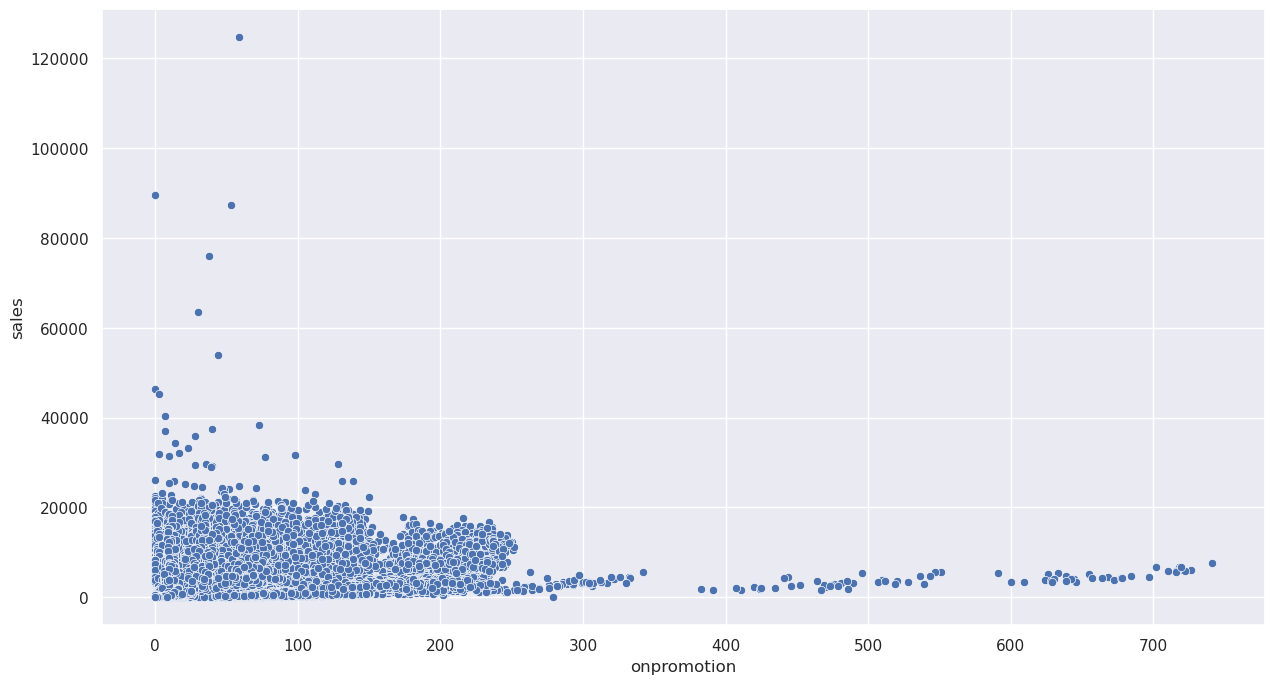

In [42]:
sns.scatterplot(data=df_total, x='onpromotion', y='sales')

In [43]:
df_total.city.value_counts()

Quito            1009800
Guayaquil         448800
Santo Domingo     168300
Cuenca            168300
Latacunga         112200
Manta             112200
Machala           112200
Ambato            112200
Quevedo            56100
Esmeraldas         56100
Loja               56100
Libertad           56100
Playas             56100
Daule              56100
Babahoyo           56100
Cayambe            56100
Salinas            56100
Puyo               56100
Guaranda           56100
Ibarra             56100
Riobamba           56100
El Carmen          56100
Name: city, dtype: int64

In [44]:
df_total.state.value_counts()

Pichincha                         1065900
Guayas                             617100
Santo Domingo de los Tsachilas     168300
Azuay                              168300
Manabi                             168300
Cotopaxi                           112200
Tungurahua                         112200
Los Rios                           112200
El Oro                             112200
Chimborazo                          56100
Imbabura                            56100
Bolivar                             56100
Pastaza                             56100
Santa Elena                         56100
Loja                                56100
Esmeraldas                          56100
Name: state, dtype: int64

In [45]:
df_total.type.value_counts()

D    1009800
C     841500
A     504900
B     448800
E     224400
Name: type, dtype: int64

In [46]:
df_total.cluster.value_counts()

3     392700
10    336600
6     336600
15    280500
13    224400
14    224400
11    168300
4     168300
8     168300
1     168300
9     112200
2     112200
7     112200
16     56100
5      56100
12     56100
17     56100
Name: cluster, dtype: int64

<AxesSubplot:xlabel='dcoilwtico', ylabel='sales'>

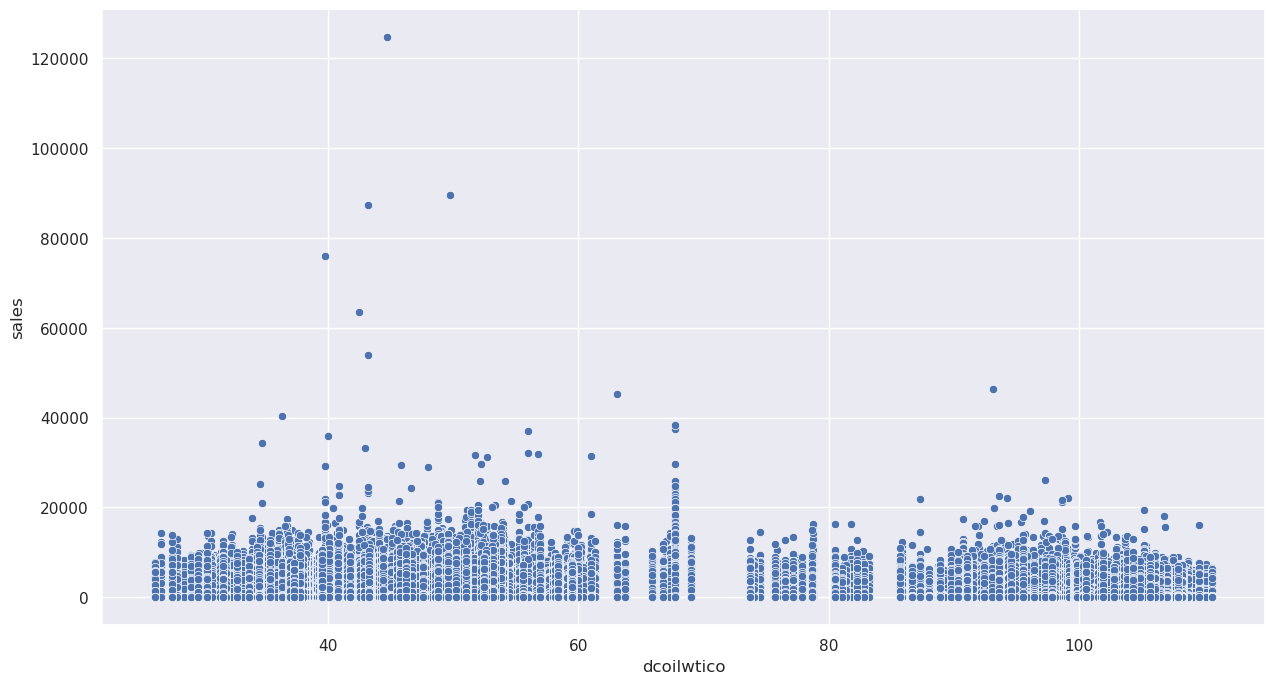

In [47]:
sns.scatterplot(data=df_total, x='dcoilwtico', y='sales')

In [48]:
df_total.national_holiday.value_counts()

0    2787048
1     242352
Name: national_holiday, dtype: int64

In [49]:
df_total.local_holiday.value_counts()

0    3017916
1      11484
Name: local_holiday, dtype: int64

<AxesSubplot:xlabel='transactions', ylabel='sales'>

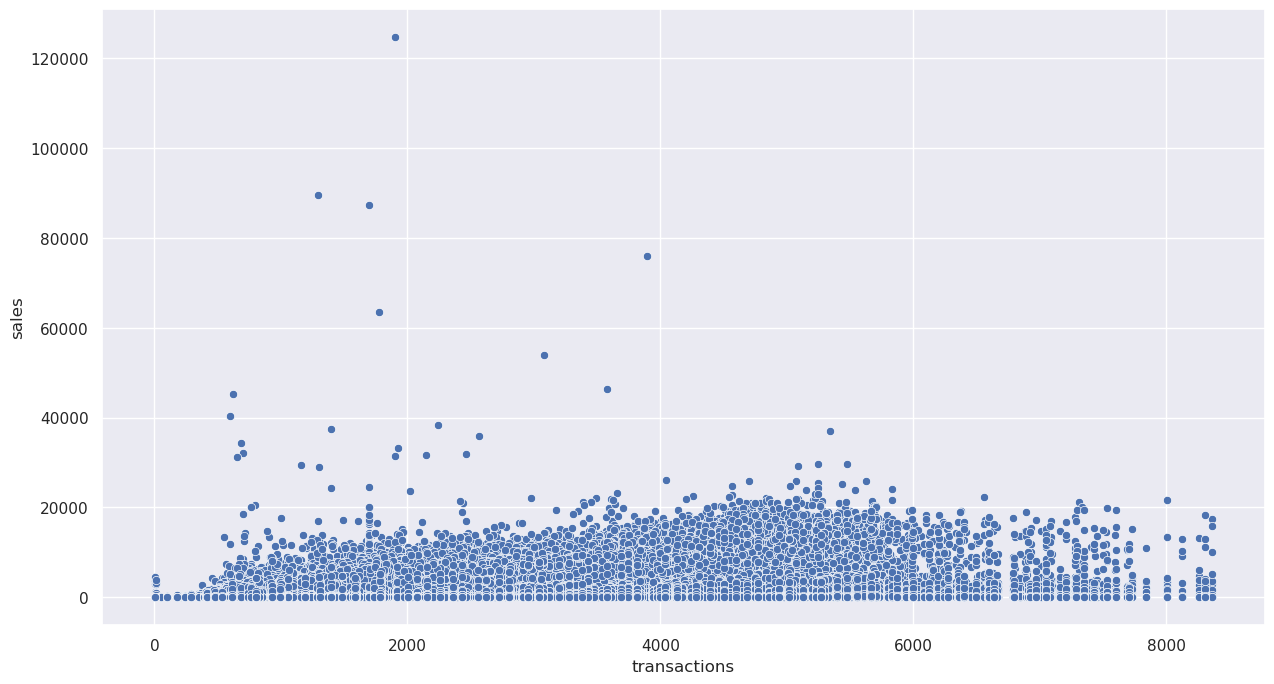

In [50]:
sns.scatterplot(data=df_total, x='transactions', y='sales')

# 불필요한 features 삭제

In [51]:
# city, state는 삭제
df_total.drop(['city', 'state'], axis=1, inplace=True)
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3029400 entries, 0 to 3029399
Data columns (total 11 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   store_nbr         int64         
 2   family            object        
 3   sales             float64       
 4   onpromotion       int64         
 5   type              object        
 6   cluster           int64         
 7   dcoilwtico        float64       
 8   national_holiday  int64         
 9   local_holiday     int64         
 10  transactions      float64       
dtypes: datetime64[ns](1), float64(3), int64(5), object(2)
memory usage: 277.3+ MB


# One-Hot-Encoding 적용

In [52]:
df_total = pd.get_dummies(df_total, columns=['type'])
# family는 나중에 필요할 때 처리하자

# 학습 데이터와 테스트 데이터를 다시 분리하기

In [53]:
## 학습 데이터 인덱스 : 0 ~ 3000887
## 학습 데이터 인덱스 : 3000888 ~ 3029399
df_total_train = df_total.iloc[0:3000888, :]
df_total_test = df_total.iloc[3000888:3029400, :]

# 학습 및 테스트 데이터를 날짜, store_nbr, family를 기준으로 나누기

In [54]:
# store_nbr, family를 기준으로 정렬하고 인덱스 재설정하기
# 테스트 데이터는 정렬 및 인덱스 재설정하면 안된다
df_total_train_sort = df_total_train.sort_values(['store_nbr', 'family'])
df_total_train_sort = df_total_train_sort.reset_index(drop=True)

In [55]:
## 1683열씩 학습 데이터를 나누어 1782개의 학습 데이터를 만든다
sub_dic_train = {}

for i in range(0, df_total_train_sort.shape[0], 1684):
    sub_name = 'sub_' + str(df_total_train_sort['store_nbr'][i]) + '_' + df_total_train_sort['family'][i]
    sub = df_total_train_sort.iloc[i:i+1683, :]
    sub_dic_train[sub_name] = sub
    
keys_list = list(sub_dic_train.keys())
keys_set = set(keys_list)
print('딕셔너리의 키 전체 갯수 : {} / 딕셔너리의 키 중복제거 갯수 : {}'.format(len(keys_list), len(keys_set)))

딕셔너리의 키 전체 갯수 : 1782 / 딕셔너리의 키 중복제거 갯수 : 1782


# 나누어진 학습데이터를 통해 시계열 예측 모델 만들기 

## 예시) : 1번 가게의 AUTOMOTIVE 제품군의 판매량 시계열 plot

<AxesSubplot:xlabel='date', ylabel='sales'>

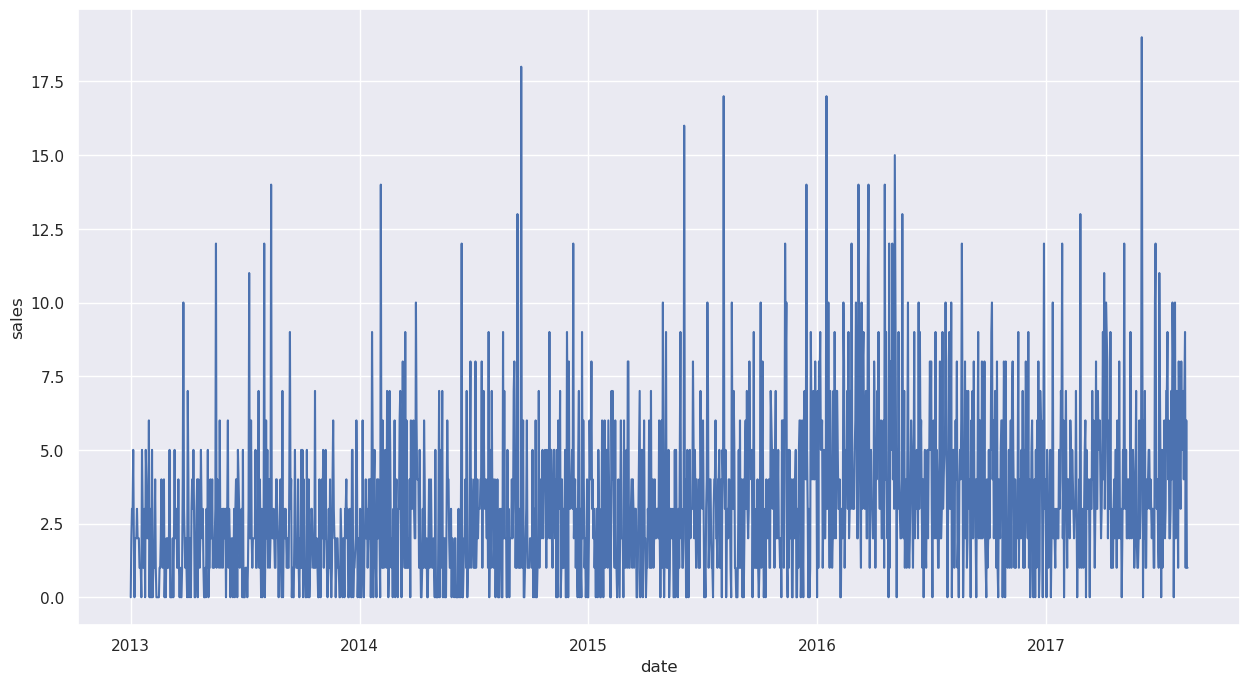

In [56]:
sns.lineplot(data=sub_dic_train['sub_1_AUTOMOTIVE'], x='date', y='sales', sizes=(50, 1500))

# ARIMA 모델 구현

## 주의 iloc는 인덱스가 아니고 현재 상태 데이터의 행의 순서이다

In [57]:
df_total_test.iloc[0:1782]

,date,store_nbr,family,sales,onpromotion,cluster,dcoilwtico,national_holiday,local_holiday,transactions,type_A,type_B,type_C,type_D,type_E
3000888,2017-08-16,1,AUTOMOTIVE,NaN,0,13,46.8,0,0,1694.602158,0,0,0,1,0
3000889,2017-08-16,1,BABY CARE,NaN,0,13,46.8,0,0,1694.602158,0,0,0,1,0
3000890,2017-08-16,1,BEAUTY,NaN,2,13,46.8,0,0,1694.602158,0,0,0,1,0
3000891,2017-08-16,1,BEVERAGES,NaN,20,13,46.8,0,0,1694.602158,0,0,0,1,0
3000892,2017-08-16,1,BOOKS,NaN,0,13,46.8,0,0,1694.602158,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3002665,2017-08-16,9,POULTRY,NaN,0,6,46.8,0,0,1694.602158,0,1,0,0,0
3002666,2017-08-16,9,PREPARED FOODS,NaN,1,6,46.8,0,0,1694.602158,0,1,0,0,0
3002667,2017-08-16,9,PRODUCE,NaN,158,6,46.8,0,0,1694.602158,0,1,0,0,0
3002668,2017-08-16,9,SCHOOL AND OFFICE SUPPLIES,NaN,14,6,46.8,0,0,1694.602158,0,1,0,0,0


# 테스트 데이터가 패턴 없이 섞여 있는지 확인해 보자

In [58]:
df_std = df_total_test.iloc[0:1782, 0:3]

for i in range(0, 16):
    df_shift = df_total_test[['date','store_nbr', 'family']].shift(-1782*1)[0:1782]
    df_std_shift = pd.concat([df_std, df_shift], axis=1)
    df_std_shift.columns = ['date1', 'store_nbr1', 'family1','date2', 'store_nbr2', 'family2']
    df_std_shift['comp'] = df_std_shift.apply(lambda row:0 if row['store_nbr1'] == row['store_nbr2'] and row['family1'] == row['family2'] else 1, axis=1)
    if df_std_shift['comp'].sum() == 0:
        print('{} : pass...'.format(i))

0 : pass...
1 : pass...
2 : pass...
3 : pass...
4 : pass...
5 : pass...
6 : pass...
7 : pass...
8 : pass...
9 : pass...
10 : pass...
11 : pass...
12 : pass...
13 : pass...
14 : pass...
15 : pass...


# test 데이터의 stor_nbr과 family의 순서를 저장하자

In [59]:
df_std.iloc[0:34]

,date,store_nbr,family
3000888,2017-08-16,1,AUTOMOTIVE
3000889,2017-08-16,1,BABY CARE
3000890,2017-08-16,1,BEAUTY
3000891,2017-08-16,1,BEVERAGES
3000892,2017-08-16,1,BOOKS
3000893,2017-08-16,1,BREAD/BAKERY
3000894,2017-08-16,1,CELEBRATION
3000895,2017-08-16,1,CLEANING
3000896,2017-08-16,1,DAIRY
3000897,2017-08-16,1,DELI


In [60]:
test_store = []

for i in range(0, df_std.shape[0], 33):
    test_store.append(df_std.iloc[i]['store_nbr'])

test_store

[1,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 2,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 3,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 4,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 5,
 50,
 51,
 52,
 53,
 54,
 6,
 7,
 8,
 9]

In [61]:
test_family = df_std.iloc[0:33]['family'].to_list()
test_family

['AUTOMOTIVE',
 'BABY CARE',
 'BEAUTY',
 'BEVERAGES',
 'BOOKS',
 'BREAD/BAKERY',
 'CELEBRATION',
 'CLEANING',
 'DAIRY',
 'DELI',
 'EGGS',
 'FROZEN FOODS',
 'GROCERY I',
 'GROCERY II',
 'HARDWARE',
 'HOME AND KITCHEN I',
 'HOME AND KITCHEN II',
 'HOME APPLIANCES',
 'HOME CARE',
 'LADIESWEAR',
 'LAWN AND GARDEN',
 'LINGERIE',
 'LIQUOR,WINE,BEER',
 'MAGAZINES',
 'MEATS',
 'PERSONAL CARE',
 'PET SUPPLIES',
 'PLAYERS AND ELECTRONICS',
 'POULTRY',
 'PREPARED FOODS',
 'PRODUCE',
 'SCHOOL AND OFFICE SUPPLIES',
 'SEAFOOD']

In [62]:
test_index = []

for store in test_store:
    for family in test_family:
        test_index.append('sub_' + str(store) + '_' + family)

test_index[-1]

'sub_9_SEAFOOD'

# sub_dic_train의 순서를 test_index의 순서와 맞춰 주어야 한다

In [63]:
list(sub_dic_train.keys())[-1]

'sub_54_SEAFOOD'

# 이거봐 다르자나...

In [64]:
sorted_sub_dic_train = {}

for key in test_index:
    sorted_sub_dic_train[key] = sub_dic_train[key]

In [65]:
len(list(sorted_sub_dic_train.keys()))

1782

In [66]:
len(test_index)

1782

In [67]:
list(sorted_sub_dic_train.keys())

for i in range(0, len(test_index)):
    if list(sorted_sub_dic_train.keys())[i] != test_index[i]:
        print('On error...')

# 이제 sorted_sub_dic_train를 사용하여 모델을 구현하면 된다

# 하나의 학습 데이터 세트로 생성된 모델에 학습 데이터를 적용하여 시계열을 잘 따라가는지 수작업으로 확인 필요

# 그냥 평균치를 예측하는 것 같다

### 학습 데이터의 마지막 16일치를 테스트 데이터로 변환해서 ARIMA 모델의 성능 확인해보자

### 15년이전 데이터는 학습에서 제외 해보자

In [76]:
def sim_page(sub_name, p=2, q=2, seasonal_check=False, m_check=1, start_date = '2015-01-01'):
    train_data_part = sorted_sub_dic_train[sub_name][sorted_sub_dic_train[sub_name]['date'] >= start_date]
    part = train_data_part['sales']
    train = part.iloc[0:part.shape[0]-16]
    test = part.iloc[part.shape[0]-16:part.shape[0]]

    kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
    adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
    n_diffs = max(kpss_diffs, adf_diffs)

    model = pm.auto_arima(y=train, d=n_diffs, start_p=0, max_p=p, start_q=0, max_q=q, m = m_check,
                             seasonal=seasonal_check, stepwise=True, trace=False)

    model_fit = model.fit(train)
    result = model_fit.predict(n_periods=16)
    results = np.asarray(result).tolist()

    plot1 = list(part)
    plot2 = (list(train))
    plot2.extend(results)
    print('{} / {}'.format(len(plot1), len(plot2)))

    x_date = train_data_part['date'].to_list()

    plt.plot(x_date, plot1)
    plt.plot(x_date, plot2)

    print('Evaluation : {}'.format(rmsle(test.to_list(), result.to_list())))

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


955 / 955
Evaluation : 0.5782019142994519


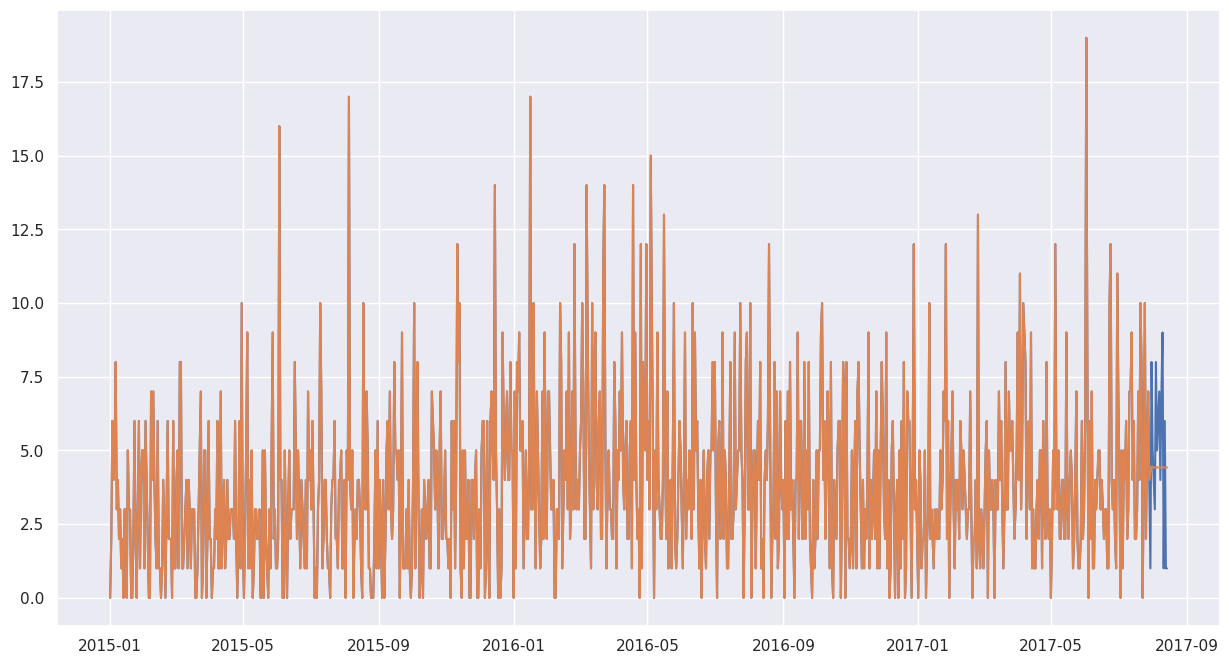

In [152]:
sim_page('sub_1_AUTOMOTIVE')

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


955 / 955
Evaluation : 0.5917284171424155


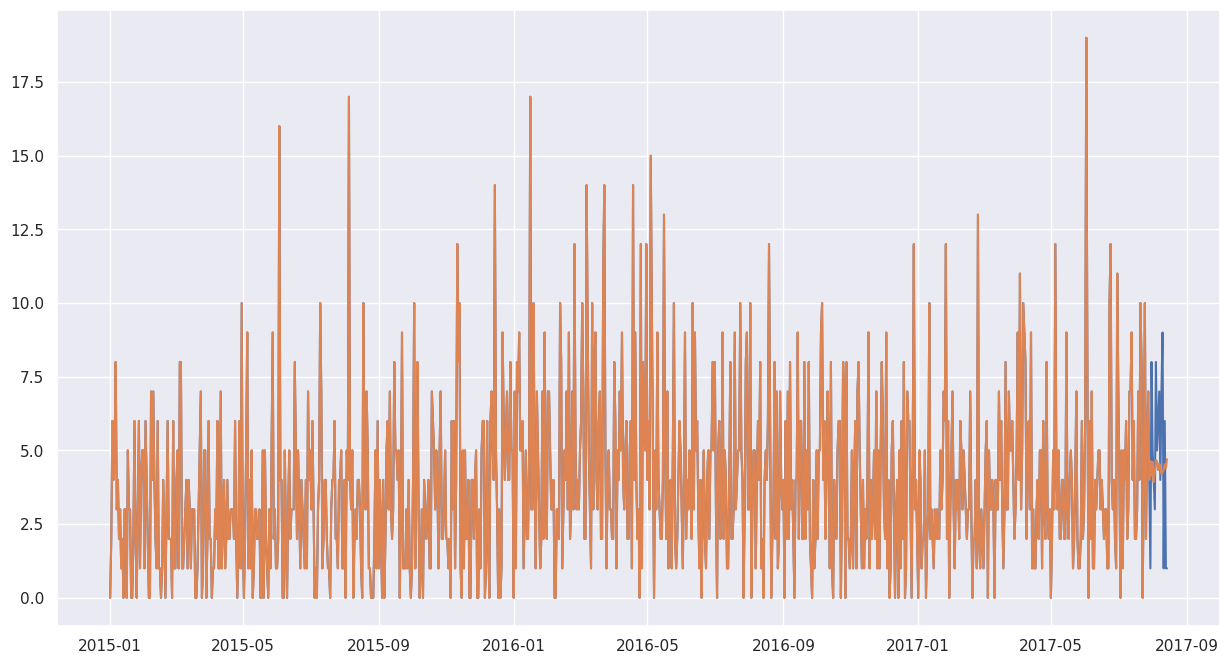

In [153]:
sim_page('sub_1_AUTOMOTIVE', p=2, q=2, seasonal_check=True, m_check=12)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


955 / 955
Evaluation : 0.5769450723391342


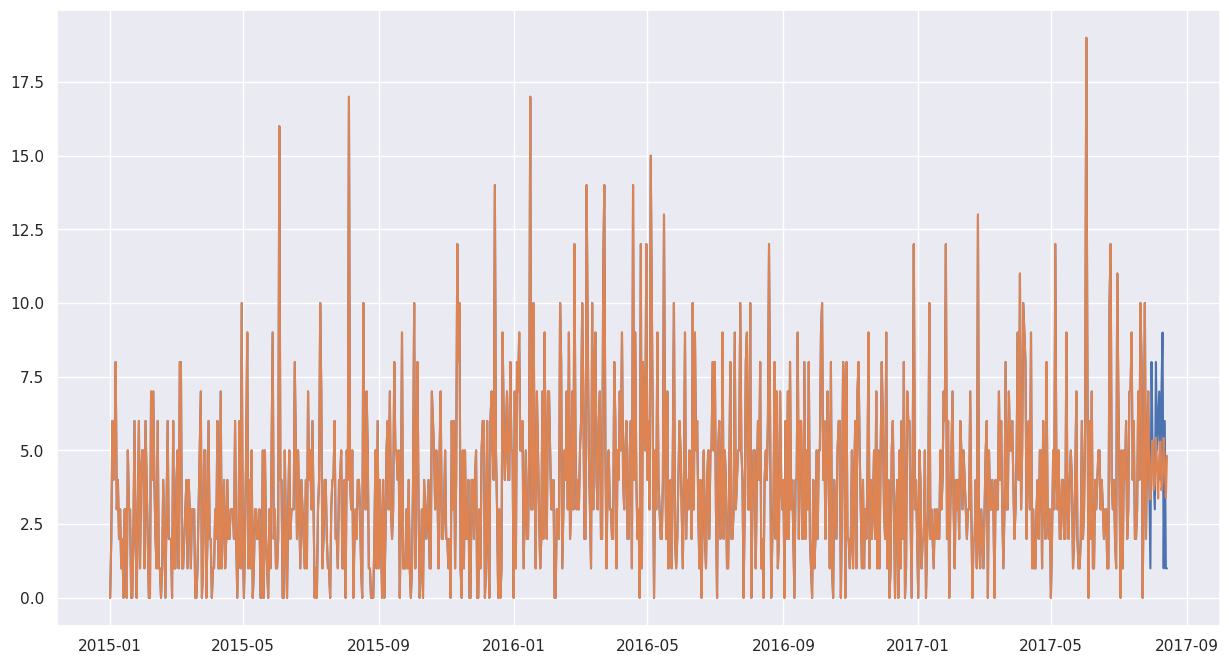

In [156]:
sim_page('sub_1_AUTOMOTIVE', p=5, q=5, seasonal_check=True, m_check=12)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


955 / 955
Evaluation : 1.2790862684908546


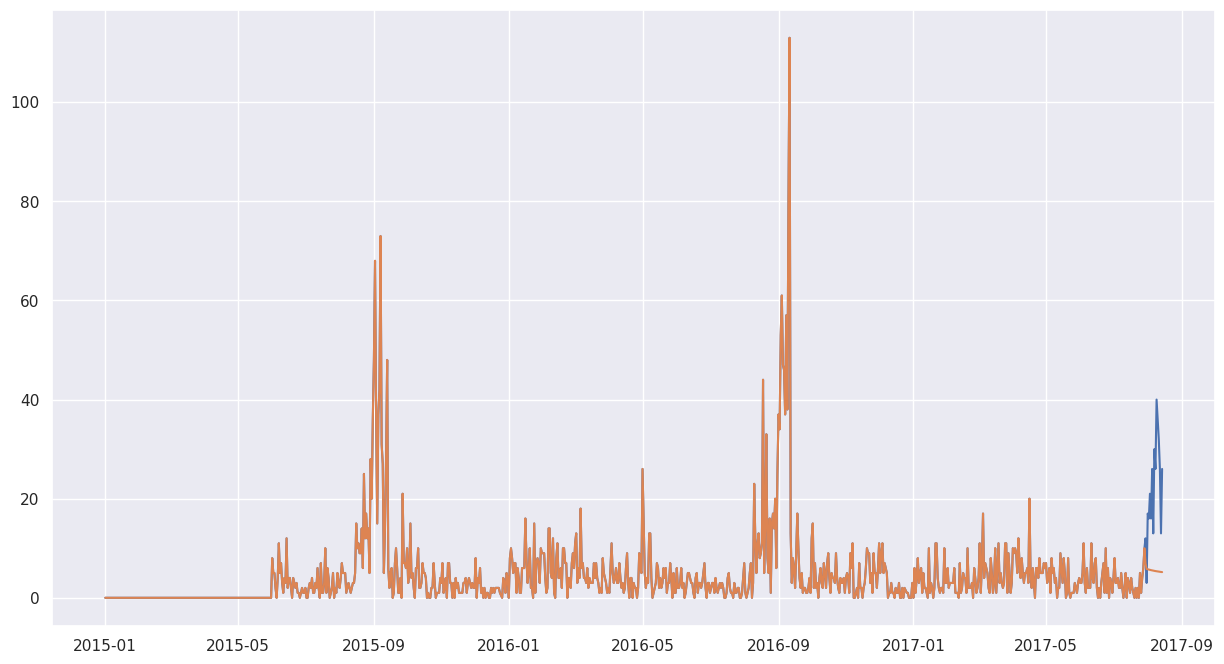

In [157]:
sim_page('sub_11_SCHOOL AND OFFICE SUPPLIES')

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


955 / 955
Evaluation : 1.2639120970910405


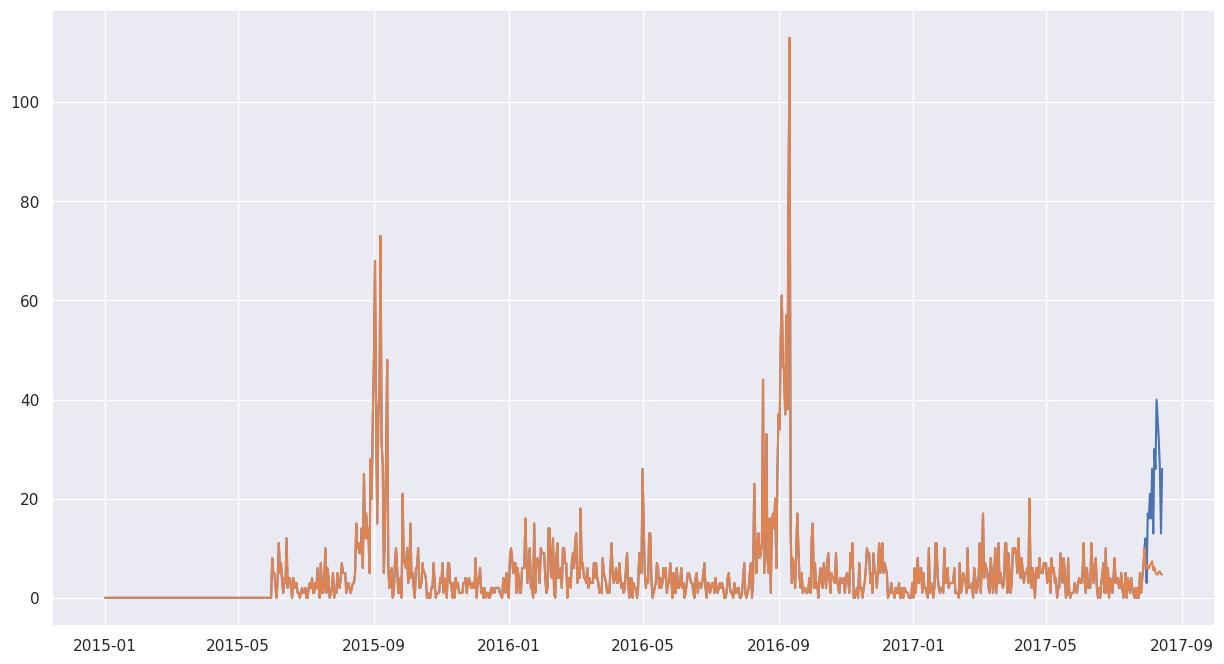

In [74]:
sim_page('sub_11_SCHOOL AND OFFICE SUPPLIES', p=5, q=5, seasonal_check=True, m_check=12)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


409 / 409
Evaluation : 0.9952573350175073


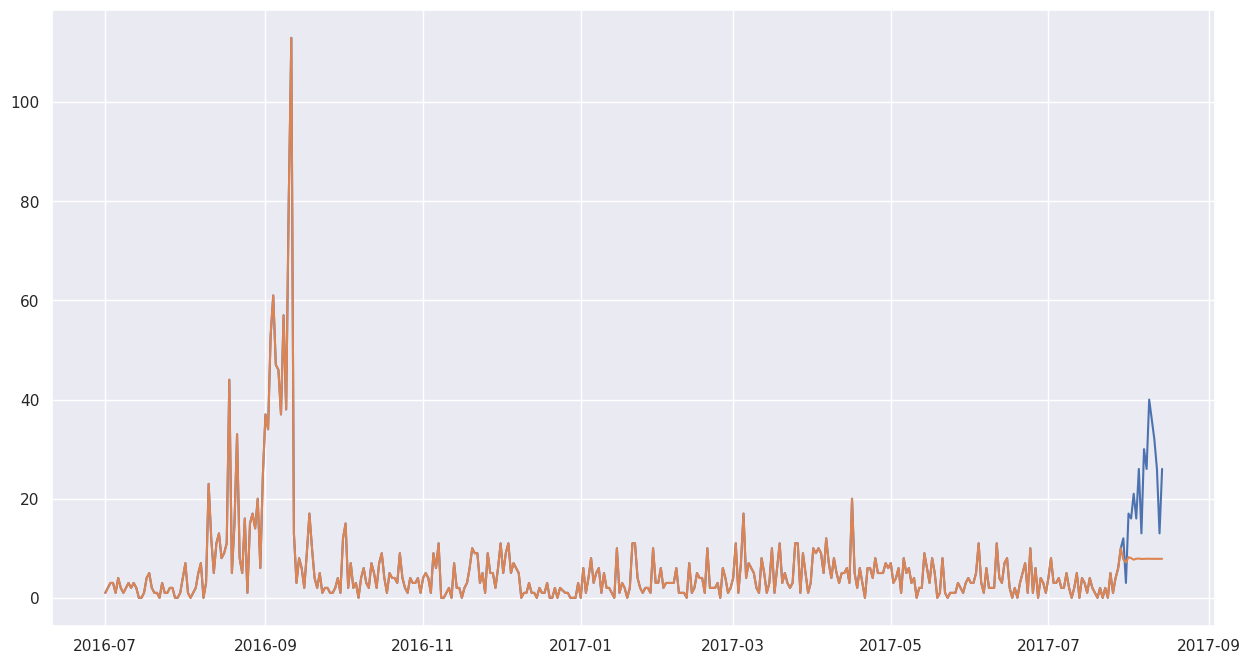

In [78]:
sim_page('sub_11_SCHOOL AND OFFICE SUPPLIES', p=5, q=5, start_date='2016-07-01')

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


409 / 409
Evaluation : 0.5763218681639872


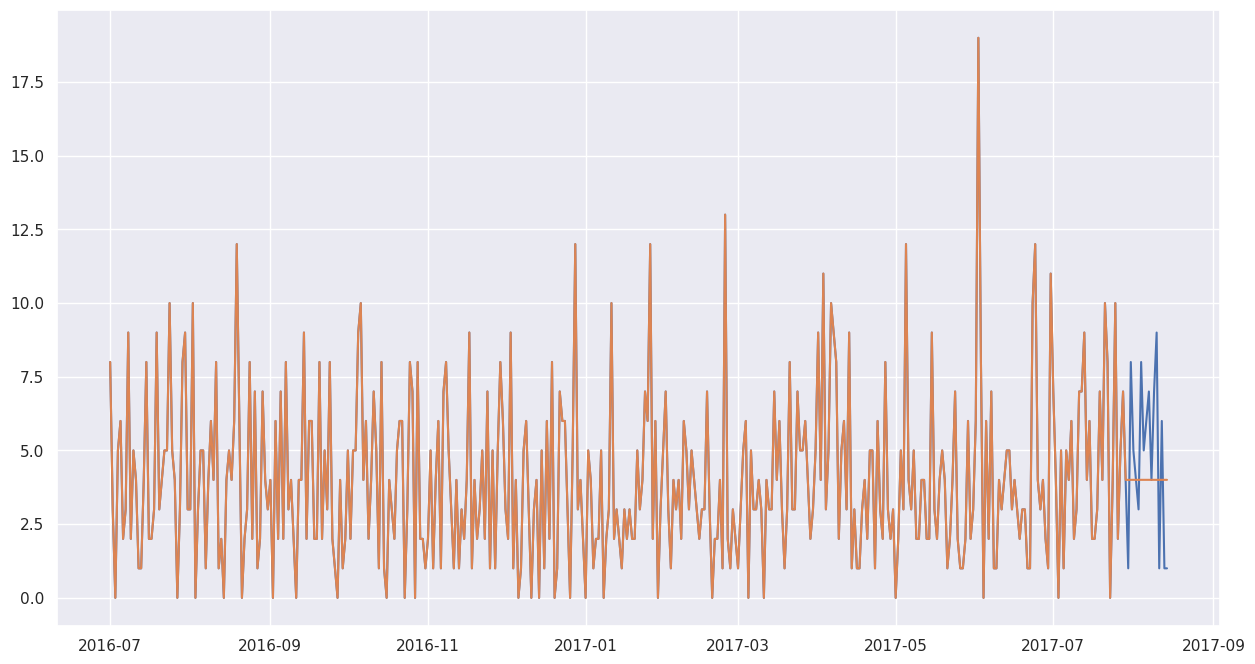

In [79]:
sim_page('sub_1_AUTOMOTIVE', p=5, q=5,start_date='2016-07-01')

In [ ]:
sim_page('sub_1_AUTOMOTIVE', seasonal_check=True, m_check=12 , p=5, q=5,start_date='2016-07-01')

In [ ]:
# results_total = []

# for key in tqdm(test_index):
#     train_data = sorted_sub_dic_train[key]['sales']
    
#     kpss_diffs = ndiffs(train_data, alpha=0.05, test='kpss', max_d=6)
#     adf_diffs = ndiffs(train_data, alpha=0.05, test='adf', max_d=6)
#     n_diffs = max(kpss_diffs, adf_diffs)

#     model = pm.auto_arima(y=train_data, d=n_diffs, start_p=0, max_p=2, start_q=0, max_q=2,
#                           seasonal=False, stepwise=True, trace=True)

#     model_fit = model.fit(train_data)    
#     result = model_fit.predict(n_periods=16)
#     results = np.asarray(result).tolist()
#     results_total.extend(results)
#     time.sleep(1)

# Submit 실행

In [ ]:
#print(len(results_total))
#submit = pd.read_csv('sample_submission.csv')
#submit['sales'] = np.array(results_total)
#submit.to_csv('sample_submission_1.csv', index=False)

# End of script